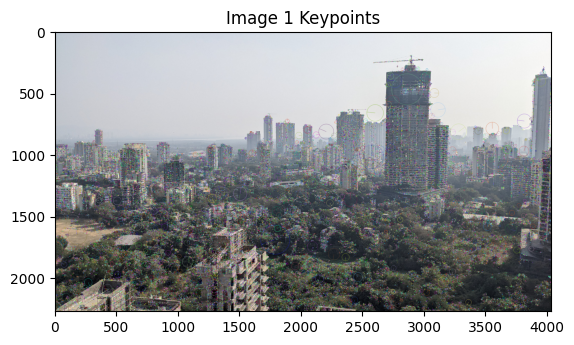

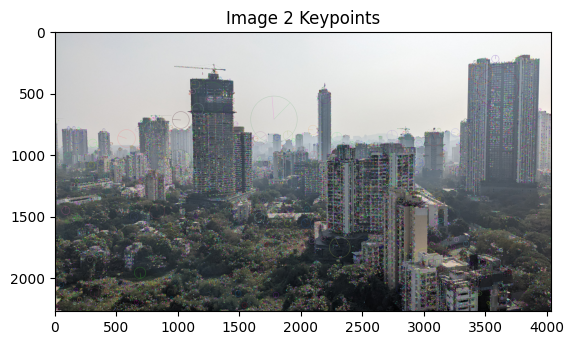

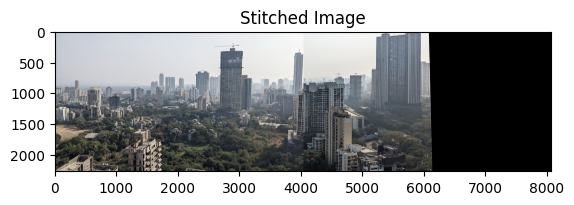

True

In [3]:
# Manual Method

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load images
img1 = cv2.imread(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\image3.jpg")  # Target image
img2 = cv2.imread(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\image4.jpg")  # Source image

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Step 2: Feature extraction using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Display keypoints for manual selection


def display_keypoints(img, keypoints, title):
    img_with_kp = cv2.drawKeypoints(
        img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()


display_keypoints(img1, keypoints1, "Image 1 Keypoints")
display_keypoints(img2, keypoints2, "Image 2 Keypoints")

# Step 3: Manual selection of points
# Replace these coordinates with manually chosen ones
points_img1 = np.array([[2688, 334], [3046, 334], [2656, 598], [
                       3192, 764]], dtype=np.float32)  # Example points
points_img2 = np.array([[1099, 392], [1444, 406], [1078, 650], [
                       1594, 824]], dtype=np .float32)  # Example points

# Step 4: Compute homography matrix
H, status = cv2.findHomography(points_img2, points_img1, cv2.RANSAC)

# Step 5: Transform and stitch
height, width, _ = img1.shape
warped_img2 = cv2.warpPerspective(img2, H, (width * 2, height))  # Warp image 2
warped_img2[0:height, 0:width] = img1  # Overlay image 1

# Display result
plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.show()

# Optional: Save the stitched image
cv2.imwrite(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\stitched_imagem.jpg", warped_img2)


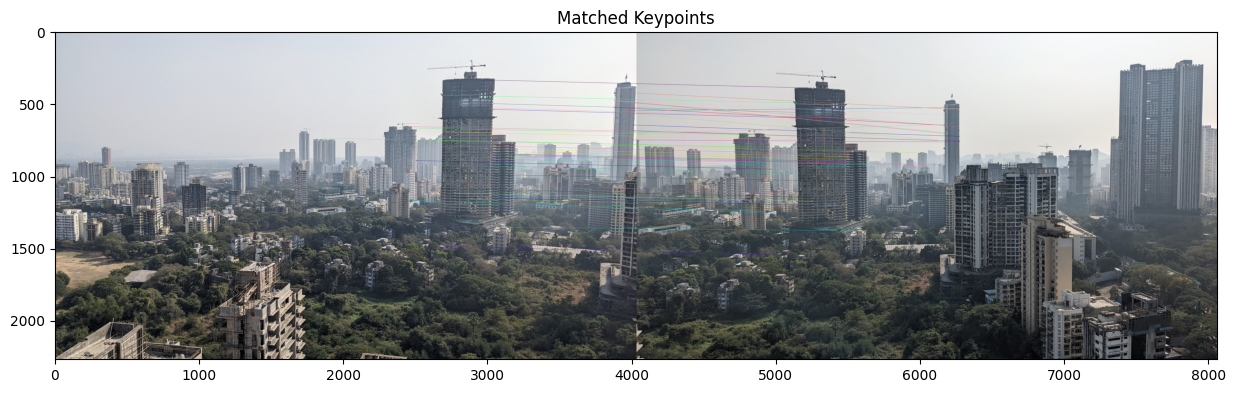

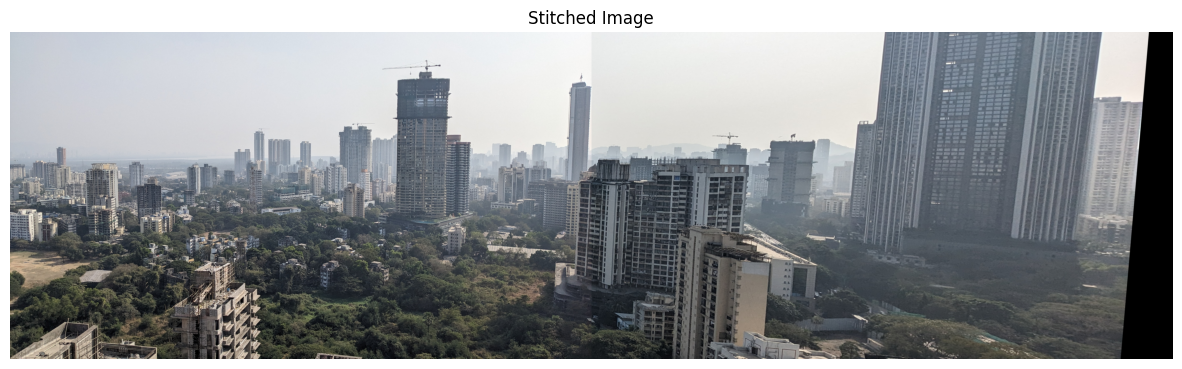

True

In [4]:
#Automatic Method.

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load images
img1 = cv2.imread(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\image3.jpg")  # Target image
img2 = cv2.imread(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\image4.jpg")  # Source image

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Step 2: Feature extraction using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# Step 3: Match features using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

# Visualize matched features (optional)
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2,
                              matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Matched Keypoints")
plt.show()

# Step 4: Extract matched points
src_pts = np.float32(
    [keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32(
    [keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute Homography matrix
H, status = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Step 5: Warp and stitch images
height, width, _ = img1.shape
warped_img2 = cv2.warpPerspective(
    img2, H, (width * 2, height))  # Warp source image
warped_img2[0:height, 0:width] = img1  # Overlay target image

# Display stitched image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
plt.title("Stitched Image")
plt.axis("off")
plt.show()

# Optional: Save the stitched image
cv2.imwrite(
    "C:\\Users\\mites\\OneDrive\\Desktop\\CVAssignment5\\stitched_image_auto2.jpg", warped_img2)


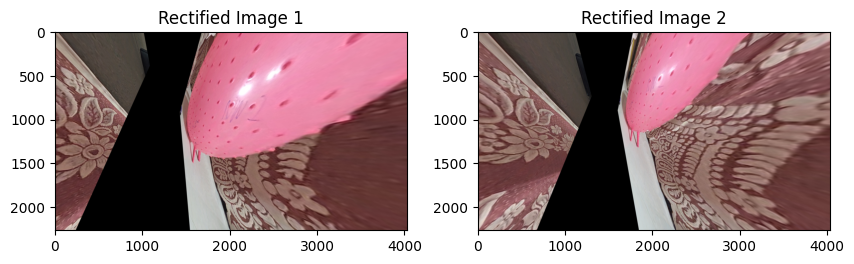

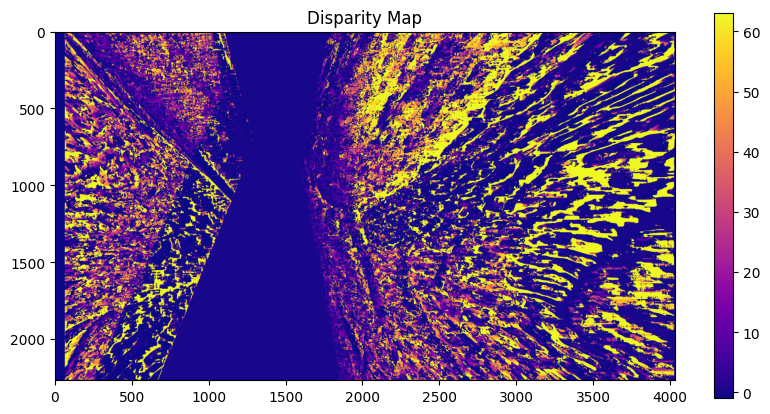

Sample 3D Points: [[-7.5076920e+01 -4.3615383e+01  3.8461540e-02]
 [-7.5038460e+01 -4.3615383e+01  3.8461540e-02]
 [-7.4820145e+01 -4.3510792e+01  3.8369305e-02]
 [-7.4781776e+01 -4.3510792e+01  3.8369305e-02]
 [-7.4743408e+01 -4.3510792e+01  3.8369305e-02]]


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_match_keypoints(img1, img2):
    # Detect keypoints and descriptors using ORB
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract matched points
    pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    return pts1, pts2

def rectify_images(img1, img2, pts1, pts2):
    # Calculate the fundamental matrix
    F, _ = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    if F is None:
        raise ValueError("Fundamental matrix could not be computed. Check your point correspondences.")

    # Stereo rectification (uncalibrated)
    h1, w1 = img1.shape[:2]
    _, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imgSize=(w1, h1))

    # Rectify images
    img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
    img2_rectified = cv2.warpPerspective(img2, H2, (w1, h1))

    return img1_rectified, img2_rectified, H1, H2

def compute_disparity_map(img1_rectified, img2_rectified):
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2GRAY)

    # Create StereoSGBM matcher
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=64,
        blockSize=9,
        P1=8 * 3 * 3 ** 2,
        P2=32 * 3 * 3 ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
    )

    # Compute disparity map
    disparity = stereo.compute(gray1, gray2).astype(np.float32) / 16.0
    return disparity

def generate_3d_depth_model(disparity_map, Q):
    # Reproject disparity map to 3D space
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
    return points_3D

def main():
    # Load images
    img1 = cv2.imread("C:\\Users\\mites\\OneDrive\\Documents\\Mitesh Manani\\IIT Jammu - M.Tech in Artificial Intelligence and Machine Learning\\Semester 2\\Computer Vision\\My Submissions\\CVAssignment5\\left.jpg")
    img2 = cv2.imread("C:\\Users\\mites\\OneDrive\\Documents\\Mitesh Manani\\IIT Jammu - M.Tech in Artificial Intelligence and Machine Learning\\Semester 2\\Computer Vision\\My Submissions\\CVAssignment5\\right.jpg")

    if img1 is None or img2 is None:
        print("Error: Images could not be loaded. Check the file paths.")
        return

    # Detect and match keypoints
    pts1, pts2 = detect_and_match_keypoints(img1, img2)

    # Step 1: Rectify images
    img1_rectified, img2_rectified, H1, H2 = rectify_images(img1, img2, pts1, pts2)

    # Visualize rectified images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1_rectified, cv2.COLOR_BGR2RGB))
    plt.title("Rectified Image 1")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_rectified, cv2.COLOR_BGR2RGB))
    plt.title("Rectified Image 2")
    plt.show()

    # Step 2: Compute disparity map
    disparity_map = compute_disparity_map(img1_rectified, img2_rectified)

    # Visualize disparity map
    plt.figure(figsize=(10, 5))
    plt.imshow(disparity_map, cmap='plasma')
    plt.colorbar()
    plt.title("Disparity Map")
    plt.show()

    # Step 3: Generate 3D depth model
    # Example Q matrix (calibration-dependent, use real calibration data in practice)
    Q = np.array([
        [1, 0, 0, -img1.shape[1] / 2],
        [0, 1, 0, -img1.shape[0] / 2],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
    ])
    points_3D = generate_3d_depth_model(disparity_map, Q)

    # Print some sample 3D points
    mask = disparity_map > disparity_map.min()
    points = points_3D[mask]

    print(f"Sample 3D Points: {points[:5]}")

if __name__ == "__main__":
    main()
